# <a id='toc1_'></a>[Quantum Chemistry Tutorial 1 - Modelling Basis](#toc0_)

1. **S. G. Nana Engo**, serge.nana-engo@facsciences-uy1.cm
    * Department of Physics, Faculty of Science, University of Yaounde I
2. **J-P. Tchapet Njafa**, jean-pierre.tchapet-njafa@univ-maroua.cm
    * Department of Physics, Faculty of Science, University of Maroua
       
December 2023

L'objectif de ce notebook est de fournir les connaissances de base en chimie quantique nécessaire résoudre un problème de chimie avec la DFT ou les algorithmes hybrides classique-quantique. De nombreux paramètres peuvent être modifiés, et certains ont un impact plus important que d’autres sur la précision et les ressources quantiques (nombre de qubits, profondeur du circuit quantique et nombre de mesures). Cet ensemble de paramètres comprend le choix de l'état initial, le choix de l'ensemble de bases et le gel des orbitales moléculaires. 

La molécule d'application est la molécule d'eau $\rm{H_2O}$ et framework principal utilisé est PySCF.

## <a id='toc1_1_'></a>[PySCF](#toc0_)

<!-- ![Pyscf.png](attachment:Pyscf.png) -->
![Pyscf.png](./Graphics/Pyscf.png)

In [4]:
import pyscf

pyscf.__version__

'2.4.0'

<!-- ![wpySCF_Logo](./Graphics/Pyscf.png) -->

**Python-based Simulations of Chemistry Framework (PySCF)** est un programme de chimie computationnelle *ab initio* implémenté nativement dans le langage de programme Python. Le package vise à fournir une plate-forme simple, légère et efficace pour le développement et le calcul de codes de chimie quantique. Il fournit diverses fonctions pour faire la théorie de Hartree-Fock, la Second-order Møller–Plesset perturbation theory (MP2), la théorie fonctionnelle de la densité (DFT), la Multi-configuration self-consistent field (MCSCF), la théorie des clusters couplés (CC) au niveau non relativiste et la théorie relativiste Hartree-Fock à 4 composants. PySCF est utilisé dans la plupart des packages de calculs quantiques pour les calculs HF (première quantification) et diverses étapes des transformations de seconde quantification.

Il est à noter que la méthode SCF ou Self Consistent Field est une méthode variationnelle où la fonction d'essai est un déterminant de Slater ou une combinaison lineaire sw déterminants. 

## <a id='toc1_2_'></a>[Structure électronique des molécules en première et seconde quantifications](#toc0_)

### <a id='toc1_2_1_'></a>[Hamiltonien d'une molécule en première quantification](#toc0_)

L'Hamiltonien d'une molécule constituée de noyaux $K$ et d'électrons $N$ est
\begin{equation*}
\mathtt{H}=\mathtt{T}_e+\mathtt{T}_n+\mathtt{U}_{en}+\mathtt{U}_{en}+\mathtt{U}_{nn},
\end{equation*}
où
- $\mathtt{T}_e= -\sum_i\frac{\hbar^2}{2m_e}\nabla^2_i$ est l'énergie cinétique électronique;
- $\mathtt{T}_n=-\sum_I\frac{\hbar^2}{2M_I}\nabla^2_I$ est l'énergie cinétique nucléaire;
- $\mathtt{U}_{en}= -\sum_{i,I}\frac{e^2}{4\pi\epsilon_0}\frac{Z_I}{|\mathbf{r}_i-\mathbf{R}_I|}$ est la répulsion Coulombienne entre les électrons et les noyaux;
- $\mathtt{U}_{ee}=+\frac{1}{2}\sum_{i\neq j}\frac{e^2}{4\pi\epsilon_0}\frac{1}{|\mathbf{r}_i-\mathbf{r}_j|}$ est la répulsion Coulombienne entre les électrons eux-mêmes;
- $\mathtt{U}_{nn}=+\frac{1}{2}\sum_{I\neq J}\frac{e^2}{4\pi\epsilon_0}\frac{Z_IZ_J}{|\mathbf{R}_I-\mathbf{R}_J|}$ est la répulsion Coulombienne entre les noyaux eux-mêmes.

$M_I$, $\mathbf{R}_I$ et $Z_I$ ($I=1,2$) désignent la masse, la position et le numéro atomique du *I*-ème noyau, et $\mathbf{r}_i$ est la position du *i*-ème électron. Par souci de concision, nous travaillons en unités atomiques, où l'unité de longueur est $a_0 = 1$ Bohr ($0.529167~\mathtt{T}imes~10^{-10}$ m), l'unité de masse est la masse électronique $m_e$ et l'unité d'énergie est 1 Hartree ($1~\textrm{Hartree}~= ~{e^2}/{4\pi\epsilon_0 a_0}~=~27.2113~\textrm{eV}$). Dénotant $M_I'=M_I/m_e$, les différents termes de l'Hamiltonien moléculaire en unités atomiques s'écrit
\begin{equation*}
\begin{split}
\mathtt{T}_e&=-\sum_i\frac{\nabla^2_i}{2}, \qquad\mathtt{T}_n= -\sum_I\frac{\nabla^2_I}{2M_I'}, 
 \qquad\mathtt{U}_{en}= - \sum_{i,I}\frac{Z_I}{|\mathbf{r}_i-\mathbf{R}_I|},\\
\mathtt{U}_{ee}&=+\frac12\sum_{i\neq j}\frac{1}{|\mathbf{r}_i-\mathbf{r}_j|}
=+\sum_{i,j>i}\frac{1}{|\mathbf{r}_i-\mathbf{r}_j|},\\
\mathtt{U}_{nn}&=+\frac{1}{2}\sum_{I\neq J}\frac{Z_IZ_J}{|\mathbf{R}_I-\mathbf{R}_J|}
=+\sum_{I,J>I}\frac{Z_IZ_J}{|\mathbf{R}_I-\mathbf{R}_J|}.
\end{split}
\end{equation*}

### <a id='toc1_2_2_'></a>[Approximation de Born-Oppenheimer](#toc0_)

Nous nous intéressons principalement à la structure *électronique* de la molécule. Comme $M'\sim10^3$, nous appliquons l'**approximation de Born-Oppenheimer**, en traitant les noyaux comme des charges ponctuelles classiques. En conséquence, le terme d'énergie cinétique nucléaire $T_n$ est négligé, $\mathtt{U}_{nn}(\mathbf{R})$ est constant et l'Hamiltonien moléculaire est approché par un Hamiltonien électronique paramétré par $\mathbf{R}$,
\begin{equation*}
\begin{split}
\mathtt{H}(\mathbf{R}) &= \mathtt{U}_{nn}+\underset{\text{One-Electron Operators}}{\mathtt{T}_e + \mathtt{U}_{en}(\mathbf{R})} + \underset{\text{Two-Electron Operator}}{\mathtt{U}{ee}}\\
&= \mathtt{U}_{nn}+\underset{\text{One-Electron Operator}}{\sum_i h(i)} + \underset{\text{Two-Electron Operator}}{\sum_{i\ne j}v(i, j)}.
\end{split}
\end{equation*}

### <a id='toc1_2_3_'></a>[Energie potentiel de surface](#toc0_)

En vertu de l'équation de $\mathtt{H}(\mathbf{R})$ préceédente, l'équation de Schrödinger indépendante du temps non relativiste écrit
\begin{equation*}
\mathtt{H}(\mathbf{R})\psi_i(\mathbf{R},\mathbf{r})=E_i(\mathbf{R})\psi_i(\mathbf{R},\mathbf{r}),
\end{equation*}
où $\psi_i(\mathbf{R},\mathbf{r})$ désigne l'un des états propres et $E_i(\mathbf{R})$ correspond aux surfaces d'énergie potentielle moléculaire (PES), ce qui est important pour comprendre les processus chimiques tels que la formation et la rupture de liaison. En règle générale, la précision du calcul du PES (Potential Energy Surface) doit être limitée à la *précision chimique* $\epsilon=1 \textrm{kcal}\textrm{mol}^{-1}(\sim 1.59\times 10^{-3}\textrm{Hartrees},\, 43.3\textrm{meV})$.

L'énergie de l'état fondamental est donnée par
\begin{equation}\tag{1} 
E_0 = \frac{\langle\psi_0|\mathtt{H}|\psi_0\rangle}{\langle\psi_0|\psi_0\rangle},
\end{equation}
où $|\psi_0\rangle$ est l'état fondamental du système. Cependant, la dimensionnalité de ce problème croît exponentiellement avec le nombre de degrés de liberté. Pour résoudre ce problème, nous aimerions préparer $|\psi_0\rangle$ sur un calculateur quantique et mesurer directement la valeur moyenne Hamiltonienne (ou $E_0$). Alors, comment pouvons-nous faire cela concrètement?

Un bon point de départ pour résoudre ce problème est la méthode Hartree-Fock (HF), autrement nous allons prendre comme fonction d'état de réféfrence la fonction d'état HF. Cette méthode rapproche un problème à N corps en N problèmes à un corps où chaque électron évolue dans le champ moyen des autres.  Il est à noter que le dénominateur de l'équation (1) n'est nécessaire que quand la fonction d'etat HF n'est pas normalisée au départ. Une facon d'améliorer cette fonction d'état HF est d'utiliser une combinaison linéaire des fonction d'état. Ce qui sera fait à travers les bases chimiques.


### <a id='toc1_2_4_'></a>[Déterminant Slater](#toc0_)

Un déterminant de Slater est un produit anti-symétrique d'un ou de plusieurs spin orbitals. Pour un système à $N$-electron, le déterminant de Slater s'écrit
\begin{equation*}
\begin{split}
\psi(\mathbf{r}_0, \mathbf{r}_1, \ldots, \mathbf{r}_{N-1})\equiv |\phi_{M-1},\cdots,  \phi_1, \phi_0 \rangle 
&=   \frac{1}{\sqrt{N!}}
\begin{vmatrix} \phi_0(\mathbf{r}_0) & \phi_1(\mathbf{r}_0) & \cdots & \phi_{M-1}(\mathbf{r}_0) \\
      \phi_0(\mathbf{r}_1) & \phi_1(\mathbf{r}_1) & \cdots & \phi_{M-1}(\mathbf{r}_1) \\
      \vdots & \vdots & \ddots & \vdots \\
      \phi_0(\mathbf{r}_{N-1}) & \phi_1(\mathbf{r}_{N-1}) & \cdots & \phi_{M-1}(\mathbf{r}_{N-1})
\end{vmatrix} \\
&\equiv |M-1,\dots, 1, 0 \rangle,
\end{split}
\end{equation*}
 L'échange des positions de deux électrons est équivalent à l'échange de deux rangées du déterminant de Slater, ce qui modifie le signe de la fonction d'état. Cela fournit la symétrie d'échange correcte pour la fonction d'état fermionique. Bien que le nombre de spin-orbitales considérées, $M$, soit généralement plus élevé que le nombre d'électrons dans le système, $N$, les électrons ne peuvent occuper que $N$ des spin-orbitales dans un déterminant Slater donné. En conséquence, le déterminant de Slater ne contient que les spin-orbitales occupées $N$.

### <a id='toc1_2_5_'></a>[Exemple d'illustration](#toc0_)

Pour rendre les correspondances plus claires, nous examinons comment une fonction d'état sera représentée pour un système quantique fictif. On considère les orbitales de spin $|A_\uparrow\rangle,\,|A_\downarrow\rangle,\,|B_\uparrow\rangle,\,|B_\downarrow\rangle$. Nous sommes libres de définir arbitrairement l'état Hartree-Fock de notre système fictif et de choisir les deux électrons dans l'orbitale $|A\rangle$. Nous sommes intéressés par la fonction d'état lorsque la composante $z$ du spin est nulle.

Labellisons chaque orbitale ainsi qu'il suit :
\begin{align*}
 &|A_\uparrow\rangle=|00\rangle=|\mathbf{0}\rangle,  &&|A_\downarrow\rangle=|01\rangle=|\mathbf{1}\rangle,
&&|B_\uparrow\rangle=|10\rangle=|\mathbf{2}\rangle,  &|B_\downarrow\rangle=|11\rangle=|\mathbf{3}\rangle.
\end{align*}
L'état de Hartree-Fock possède les deux électrons dans les orbitales $|A\rangle$. Un état HF incorrectement symétrisé serait donc $|A_\uparrow\rangle_1|A_\downarrow\rangle_2 = |\mathbf{0}\rangle_1|\mathbf{1}\rangle_2$, où les indices indiquent l'électron décrit par chaque orbitale. La fonction d'état HF correctement antisymétrisée serait 
\begin{equation*}
\begin{split}
    |\Psi_{\mathrm{HF}}\rangle =  \frac{1}{\sqrt{2}}
		\begin{vmatrix}
		A_\uparrow(\mathbf{x}_0) & A_\downarrow(\mathbf{x}_0)\\
		A_\uparrow(\mathbf{x}_1) & A_\downarrow(\mathbf{x}_1)\\
		\end{vmatrix}
		&= \frac{1}{\sqrt{2}}  \Big( A_\uparrow(\mathbf{x_0}) A_\downarrow(\mathbf{x_1}) - A_\downarrow(\mathbf{x_0}) A_\uparrow(\mathbf{x_1})  \Big)\\
&=\frac{1}{\sqrt{2}} (|\mathbf{0}\rangle_1|\mathbf{1}\rangle_2 - |\mathbf{1}\rangle_1|\mathbf{0}\rangle_2 ).
\end{split}
\end{equation*}
Si nous considérons maintenant les excitations au-dessus de l'état HF, alors une fonction d'état générale avec $s_z=0$ qui a été correctement antisymétrisée est
donnée par
\begin{equation*}
\begin{aligned}
|\Psi\rangle =& \frac{\alpha}{\sqrt{2}}(|\mathbf{0}\rangle_1|\mathbf{1}\rangle_2 - |\mathbf{1}\rangle_1|\mathbf{0}\rangle_2 ) 
+\frac{\beta}{\sqrt{2}} (|\mathbf{2}\rangle_1|\mathbf{3}\rangle_2 - |\mathbf{3}\rangle_1|\mathbf{2}\rangle_2 ) \\
+& \frac{\gamma}{\sqrt{2}} (|\mathbf{0}\rangle_1|\mathbf{3}\rangle_2 - |\mathbf{3}\rangle_1|\mathbf{0}\rangle_2 ) + \frac{\delta}{\sqrt{2}} (|\mathbf{1}\rangle_1|\mathbf{2}\rangle_2 - |\mathbf{2}\rangle_1|\mathbf{1}\rangle_2 ).
\end{aligned}
\end{equation*}
Comme nous avons $N=2$ électrons et $M=4$ spin-orbitales, nous pouvons voir que nous avons seulement besoin de $N \lceil\mathrm{log_2}(M)\rceil = 2 \times \lceil\mathrm{log_2}(4)\rceil = 4$ qubits pour stocker la fonction d'état.


## <a id='toc1_3_'></a>[Seconde quantification - Construction d'un opérateur Hamiltonien fermionique](#toc0_)

### <a id='toc1_3_1_'></a>[Génération des intégrales moléculaires](#toc0_)

L'Hamiltonien  est exprimé dans la base des solutions de la méthode HF, également appelées Orbitales Moléculaires (OM) :
$$
\mathtt{H}_{elec}=\sum_{pq} h_{pq} a^{\dagger}_p a_q + 
\frac{1}{2} \sum_{pqrs} h_{pqrs}  a^{\dagger}_p a^{\dagger}_q a_r  a_s
$$
avec 
* les **intégrales à 1 électron**
$$
h_{pq} = \int \phi^*_p(r) \left( -\frac{1}{2} \nabla^2 - \sum_{I} \frac{Z_I}{|\mathbf{r}_i-\mathbf{R}_I|} \right)   \phi_q(r)d\mathbf{r}
$$
qui décrivent l’énergie cinétique des électrons individuels et leurs interactions Coulombiennes avec les champs électriques du noyau ;
* et **intégrales à 2 électrons**
$$
h_{pqrs} = \int \frac{\phi^*_p(r_1)  \phi^*_q(r_2) \phi_r(r_2)  \phi_s(r_1)}{|\mathbf{r}_1-\mathbf{r}_2|}d\mathbf{r}_1d\mathbf{r}_2,
$$
décrivent les interactions Coulombiennes entre les électrons;
* $a^\dagger_p$ l'**opérateur de création** d'un électron sur le spin-orbite $p$;
* $a_q$ l'**opérateur d'annihilation** d'un électron sur sur le spin-orbite $q$;
* $a^{\dagger}_p a_q $ est l'**opérateur d'excitation**, qui excite un électron du spin-orbite occupé $\phi_q$ vers le spin-orbite inoccupé $\phi_p$.

Les MO ($\phi_u$) peuvent être occupés ou virtuels (inoccupés). Un MO peut contenir 2 électrons. Ces MO sont les solutions de la méthode HF, où chaque l´electron est soumis au champ moyen créé par les autres électrons. Cependant, dans ce qui suit, nous travaillons en fait avec des orbitales de spin qui sont associées à un spin up ($\alpha$) d'électron spin down ($\beta$). Ces deux spins sont également communément désignés par $\alpha$ et $\beta$, respectivement. Ainsi, les orbitales de spin peuvent contenir un électron ou être inoccupées.

Dans le tableau ci-dessous resume les correspondances première-seconde quantification des divers éléments du Hamiltonien moléculaire. 
$$
\begin{array}{|l|l|l|}\hline
\textbf{Approximation BO}  &  \textbf{Combinaison en 2e quantification} &  \textbf{Description}
\\\hline
-\frac12\sum_i\nabla^2_i & -\frac12\sum_{p,q}\langle p|\nabla^2_p|q\rangle a^\dagger_p a_q & \mathtt{T}_e \\\hline
 -\sum_{i,I}\frac{Z_I}{|\mathbf{r}_i-\mathbf{R}_I|} &
 -\sum_{p,q} \langle p|\frac{Z_I}{|\mathbf{r}_p-\mathbf{R}_I|}|q\rangle a^\dagger_p a_q
 & \mathtt{U}_{en}\\\hline
\sum_{i,j>i}\frac{1}{|\mathbf{r}_i-\mathbf{r}_j|} & 
\sum_{p,q,r,s}\langle pq \big|\frac{1}{|\mathbf{r}_i-\mathbf{r}_j|}\big|rs\rangle a^\dagger_p a^\dagger_q a_r a_s & 
 \mathtt{U}_{ee}\\\hline
\end{array}
$$

*Un des avantages apporté par le formalisme de seconde quantification est que la propriété d'anti-symétrie des fonctions d'état pour l'échange de fermions identiques, prise en compte manuellement dans une approche de première quantification en considérant les déterminants de Slater, est automatiquement imposée par le relations d'anti-commutation des opérateurs de création et d'annihilation. Cependant, le prix à payer est de travailler avec un nombre non fixe de particules, qui reste de toute façon une quantité conservée.*

### <a id='toc1_3_2_'></a>[Répresentation nombre d'occupation](#toc0_)

En seconde quantification, le déterminant de Slater est représenté par un **vecteur nombre d'occupation**
\begin{equation*}
|f\rangle =|f_{M-1},\dots,f_{i-1},f_i,f_{i+1},\dots, f_0\rangle, 
\end{equation*}
avec
- $f_i=1$ lorsque le spin-orbital $\phi_i$ est occupé et donc présent dans le déterminant de Slater;
- $f_i = 0$ lorsque le $\phi_i$ spin-orbital est vide et donc absent du déterminant de Slater.

- Le vecteur $|f_i\rangle$ est appelé **vecteur nombre d'occupation de l'orbite fermionique i**, parce que
\begin{align*}
& |0\rangle=\begin{pmatrix}1\\0\end{pmatrix}:\text{état vide}, & |1\rangle=\begin{pmatrix}0\\1\end{pmatrix}:\text{état occupé}.
\end{align*}

Dans la deuxième représentation de quantification, au lieu de poser la question *Quel électron est dans quel état?*, nous posons la question *combien de particules y a-t-il dans chaque état?*.

### <a id='toc1_3_3_'></a>[Opérateurs fermioniques](#toc0_)

Les opérateurs fermioniques $a^\dagger_i$ et $a_i$ obéissent aux relations d'anticommutation fermioniques suivantes:
\begin{align*}
&\{a_p,a^\dagger_q\} = a_pa^\dagger_q + a^\dagger_q a_p = \delta_{pq}, 
&\{a_p, a_q \} = \{a^\dagger_p, a^\dagger_q\} = 0 .
\end{align*}
La nature fermionique des électrons implique que les fonctions d'état à plusieurs électrons doivent être antisymétriques par rapport à l'échange de particules. Cela se reflète dans la manière dont les opérateurs de création fermionique et d'annhilation agissent sur les déterminants $|f\rangle$:
\begin{equation*}
\begin{aligned}
&a_i|f_{M-1},\dots,f_{i-1},f_i,f_{i+1},\dots, f_0\rangle = \delta_{f_i,1}
(-1)^{\sum_{m<i}f_m}|f_{M-1},\dots,f_{i-1},f_i\oplus 1,f_{i+1},\dots, f_0\rangle,\\
&a^\dagger_i|f_{M-1},\dots,f_{i-1},f_i,f_{i+1},\dots, f_0\rangle = \delta_{f_i,0}
(-1)^{\sum_{m<i}f_m}|f_{M-1},\dots,f_{i-1},f_i\oplus 1,f_{i+1},\dots, f_0\rangle`,  \\
&a|0\rangle=a^\dagger|1\rangle=0.
\end{aligned}
\end{equation*}
- Le terme de phase $p_i=(-1)^{\sum_{m<i}f_m}$ désigne la parité qu'impose l'anti-symétrie d'échange des fermions.
    - $p_i=-1$ si le nombre d'électrons est impair dans ces orbitales de spin,
    - $p_i= 1$ si le nombre d'électrons est pair dans ces orbitales de spin.

- Le symbole $\oplus$ représente l'addition modulo 2, i.e.,  $1 \oplus 1=0 $ et $0 \oplus 1=1$.

- L'opérateur de création $a^\dagger_i$ met un électron dans une orbitale inoccupée *i* ou dans $|f_i\rangle$.

- L'opérateur d'annihilation $a_i$ supprime un électron dans une orbitale occupée *i* ou en $|f_i\rangle$.

- $a_i^2 =(a^\dagger_i)^2= 0$ pour tout $i$. On ne peut pas créer ou anéantir un fermion dans le même mode deux fois.

Par example,
\begin{align*} 
&a^\dagger_1 |0\rangle_1 = |1\rangle_1,&&a^\dagger_1 |1\rangle_1 =(a^\dagger_i)^2|0\rangle_1= 0,&& a_1 |1\rangle_1 =|0\rangle_1,&a_1 |0\rangle_1 =a_1^2|1\rangle_1=0. 
\end{align*}
Notez qu'ici $a^\dagger_1|1\rangle_1=0$ et $a_1 |0\rangle_1=0$ signifie le vecteur zéro et non $|0\rangle_1$. 

En utilisant également de tels opérateurs, nous pouvons exprimer
\begin{equation*}
|0\rangle |1\rangle |1\rangle |0\rangle = a^\dagger_1a^\dagger_2 |0\rangle^{\otimes 4}.
\end{equation*}

 L'opérateur d'occupation orbitale est donné par
\begin{align*}
&n_i = a^\dagger_i a_i, &n_i |f_{M-1},\dots,f_i,\dots, f_0\rangle= f_i |f_{M-1},\dots,f_i,\dots, f_0\rangle,
\end{align*}
et il compte le nombre d'électrons dans une orbitale donnée, c'est-à-dire
\begin{align*} 
&n_i |0\rangle_i = 0, &n_i |1\rangle_i = |1\rangle_i. 
\end{align*}

### <a id='toc1_3_4_'></a>[Exercise](#toc0_)

In **Exemple d'illustration** above, we have considered a fictitious system described by spin orbitals $|A_\uparrow\rangle,\,|A_\downarrow\rangle,\,|B_\uparrow\rangle,\,|B_\downarrow\rangle$ labelled as
\begin{align*}
 &|A_\uparrow\rangle=|00\rangle=|\mathbf{0}\rangle,  &&|A_\downarrow\rangle=|01\rangle=|\mathbf{1}\rangle,
&&|B_\uparrow\rangle=|10\rangle=|\mathbf{2}\rangle,  &|B_\downarrow\rangle=|11\rangle=|\mathbf{3}\rangle.
\end{align*}
We assume that the Hartree-Fock state for this system **has both electrons occupying the $|A\rangle$ orbitals**. We store the occupations of the spin orbitals $|A_\uparrow\rangle,\,|A_\downarrow\rangle,\,|B_\uparrow\rangle,\,|B_\downarrow\rangle$ which we order as 
$|f_{B_\downarrow},f_{B_\uparrow},f_{A_\downarrow},f_{A_\uparrow}\rangle$, with $f_i=0,1$ (in the fermionic Fock space).

1. Write down, in the fermionic Fock space, the Hartree-Fock state $|\Psi_{\rm HF}\rangle$, that is, the corresponding of the antisymmetrized Slater deter-
minant obtained in **Exemple d'illustration**.
$$
|\Psi_{\rm HF}\rangle = |0011\rangle .
$$
1. Write down, in the fermionic Fock space, the $s_z = 0$ state function.
$$
|\Psi_{\rm HF}\rangle = \alpha|0011\rangle + \beta|1100\rangle + |1001\rangle + |0101\rangle .
$$


## <a id='toc1_4_'></a>[Calcul du champ moyen ou mean-field](#toc0_)

Le calcul du champ moyen est généralement la première étape de toutes les approches post Hartree-Fock. Les approches en champ moyen résolvent l'équation de Schrödinger en faisant la moyenne du terme de répulsion électron-électron de manière auto-cohérente ou SCF. En d’autres termes, chaque électron n’interagit pas explicitement avec les autres électrons.

Les trois méthodes HF communément utilisées sont (voir la figure ci-dessous) :
![HF_Orb.png](./Graphics/HF_Orb.png)
<!-- <center>
 <img src='./Graphics/HF_Orb.png' width=400 /> 
</center> -->

1. **RHF (Restricted Hartree – Fock)** utiliśee pour des molécules à couches pleines ou fermées. Les spin-orbitales sont soit $\alpha$, soit $\beta$ et tous les orbitales sont doublement occupés par des spin-orbitales $\alpha$ et $\beta$;</br> 
2. **ROHF (Restricted Open-Shell Hartree–Fock)** utilisée pour des molécules à couches ouvertes où le nombre d'électrons les orbitales n'est pas le même. ROHF utilise autant que possible les orbitales doublement occupées et les orbitales une fois occupées par les électrons non-apariés;
3. **UHF (Unrestricted Hartree-Fock)** utilisée pour des molécules à couches ouvertes où le nombre d'électrons les orbitales n'est pas le même. Les orbitales UHF peuvent avoir avoir des spin $\alpha$ ou $\beta$, mais les orbitales $\alpha$ et $\beta$ peuvent avoir des composants spatiales différents.

Les équivalents DFT sont,

4. **RKS (Kohn-Sham restreint)**,
6. **ROKS (Restricted Open-Shell Kohn – Sham)**,
5. **UKS (Kohn-Sham sans restriction)**.

### <a id='toc1_4_1_'></a>[Information sur la molécule - Création de l'objet molecule avec `pyscf.gto.Mole()`](#toc0_)

Lors de la définition d'une molécule, on spécifie les propriétés moléculaires. 
* L’une d’elles est la charge totale du système, c’est-à-dire la différence entre le nombre d’électrons et la charge nucléaire totale (la valeur par défaut est 0). 
* Une autre quantité importante à spécifier est le spin, défini par la différence entre le nombre d'électrons alpha et bêta (la valeur par défaut est 0). Cela permet de modéliser des systèmes radicalaires : un spin de 0 caractérise une molécule à couche restreinte tandis qu'un spin différent de 0 définit un système à couche ouverte.

Considérons le dimère d'eau (deux molécules d'eau à liaison hydrogène) illustré par la figure suivante

<!-- ![water_dimer.jpg](attachment:water_dimer.jpg) -->
![water_dimer.jpg](./Graphics/water_dimer.jpg)


In [37]:
from pyscf import gto # Gaussian type orbitals
import py3Dmol

mol_xyz = """
    O  -1.551007  -0.114520   0.000000
    H  -1.934259   0.762503   0.000000
    H  -0.599677   0.040712   0.000000
    O   1.350625   0.111469   0.000000
    H   1.680398  -0.373741  -0.758561
    H   1.680398  -0.373741   0.758561""" # Ref: https://cccbdb.nist.gov/expgeom2x.asp

DWat_mol=gto.Mole(
    atom=mol_xyz,
    basis='cc-pVDZ',
    charge=0,      # 0 by default
    spin=0,        # 0 by default, defined as (n_up - n_down)
    unit='Angstrom' # Can also be 'Bohr'
)

# 3D representation
xyz_view = py3Dmol.view(width=300,height=300)
xyz_view.addModel(DWat_mol.tostring(format="xyz"),'xyz')
xyz_view.setStyle({'stick':{}})
xyz_view.zoomTo()
xyz_view.show()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [39]:
DWat_mol.build()

In [40]:
print(f'Le nombre total d\'électrons est {DWat_mol.nelectron} et le nombre total d\'électrons (alpha, béta) est {DWat_mol.nelec}')
print(f'Le nombre d\'orbitales atomiques, dans la base {DWat_mol.basis}, est {DWat_mol.nao_nr()}')
print(f'L\'énergie nucléaire vaut {DWat_mol.energy_nuc()} Hartrees')

Le nombre total d'électrons est 20 et le nombre total d'électrons (alpha, béta) est (10, 10)
Le nombre d'orbitales atomiques, dans la base cc-pVDZ, est 48
L'énergie nucléaire vaut 36.66284801418409 Hartrees


### <a id='toc1_4_2_'></a>[Création d'un objet mean-field (mf) avec `scf.RHF()`](#toc0_)

Pour la plupart des usages, les types de calculs SCF pertinents seront :

1. RHF (Restricted Hartree – Fock)
2. UHF (Hartree-Fock sans restriction)
3. ROHF (Restricted Open-Shell Hartree–Fock)


L'initialisation de l'objet champ moyen pour ces six types de calculs est illustrée ci-dessous. Ces classes nécessitent au moins un argument, à savoir un objet molécule, mol.

1. `mf=scf.RHF(mol)`
2. `mf=scf.UHF(mol)`
3. `mf=scf.ROHF(mol)` (où mol est définie comme étant à couche ouverte (open-shell), mol.spin!=0)
4. `mf=scf.RKS(mol)`
5. `mf=scf.UKS(mol)`
6. `mf=scf.ROKS(mol)` (où mol est définie comme open-shell, mol.spin!=0)

La première étape consiste à créer l'objet mean-field (RHF dans ce cas)

In [41]:
from pyscf import scf

mf=scf.RHF(DWat_mol)

Par la suite, on exécute le caclul avec la méthode `.run()`ou `.kernel()

In [42]:
mf.kernel()

converged SCF energy = -152.062536249621


-152.06253624962068

Une fois l'exécution du noyau (kernel) SCF achevée, l'objet mean-field (mf) est mis à jour avec plusieurs attributs de sortie utiles :
1. `mf.mo_occ` - Occupation MO (vecteur de longueur égale au nombre de MO)

In [43]:
mf.mo_occ

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [44]:
import plotly.express as px

# Plot the MO Occupations
fig = px.line(y=mf.mo_occ, markers=True, title="Molecular Orbital (MO) Occupations")
fig.update_layout(xaxis_title="Orbital Index (0-Based)", yaxis_title="MO Occupation")
fig.show()

In [46]:
# Plot the MO Energies (i.e. eigenvalues of the Fock matrix)
fig = px.line(y=mf.mo_energy, markers=True, title="Molecular Orbital (MO) Energies")
fig.update_layout(xaxis_title="Orbital Index (0-Based)", yaxis_title="MO Energies")
fig.show()

Pour avoir les indexes du LUMO et l'HOMO

In [10]:
lumo_idx = mf.mo_occ.tolist().index(0.)
homo_idx = lumo_idx - 1
print(f'Les indexes du (HOMO,LUMO) sont {homo_idx,lumo_idx}')

Les indexes du (HOMO,LUMO) sont (9, 10)


2. `mf.e_tot` - Énergie SCF totale en unités de Hartrees

In [11]:
mf.e_tot

-152.06253624962085

On peut aussi spécifier les paramètres de calculs du mf.

In [12]:
mf=scf.RHF(DWat_mol)

mf.conv_tol=1e-12 # the difference in the SCF energy (in Hartrees) between two successive cycles
mf.conv_tol_grad=1e-8 # the root-mean-square of the orbital gradient
mf.direct_scf_tol=1e-13 #the threshold for discarding integrals
mf.init_guess='atom' #  vital for the efficient completion of the SCF procedure
mf.max_cycle=100 # the maximum number of SCF cycles that should be performed before the calculation terminates. For systems that are notoriously difficult to converge, the value should be increased to 100 or even 1000
mf.max_memory=4000 #determines the maximum amount of memory (in Megabytes) that PySCF is allowed to utilize during the SCF procedure
mf.verbose=4 #controls the print level for the mean-field objec

mf.kernel()



******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = atom
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-12
SCF conv_tol_grad = 1e-08
SCF max_cycles = 100
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmp4vi6a445
max_memory 4000 MB (current use 128 MB)
Initial guess from superposition of atomic densities.
init E= -151.923910263398
  HOMO = -0.506362393579804  LUMO = 0.060158277334186
cycle= 1 E= -151.971261051283  delta_E= -0.0474  |g|= 0.695  |ddm|=  1.9
  HOMO = -0.355909241468543  LUMO = 0.165885627805499
cycle= 2 E= -152.039403644196  delta_E= -0.0681  |g|= 0.363  |ddm|= 0.594
  HOMO = -0.463346026699717  LUMO = 0.158515477200658
cycle= 3 E= -152.062105921212  delta_E= -0.0227  |g|= 0.035  |ddm|= 0.207
  HOMO = -0.460540265791264  LUMO = 0.164019165927359
cycle= 4 E= -152.062505679448  delta_E= -0.0004  |g|= 0.0081  |ddm|= 0.0317
  HOMO = -0.461

-152.06253624962335

### <a id='toc1_4_3_'></a>[Création d'un objet mean-field (mf) avec `scf.RKS()`](#toc0_)

La méthode SCF la plus largement utilisée en chimie quantique est sans aucun doute la théorie de la fonctionnelle de la densité (DFT), et exécuter un calcul DFT dans PySCF est presque aussi simple que d'exécuter un calcul Hartree-Fock.

Afin d'accéder à des fonctions supplémentaires qui ne relèvent pas de la norme SCF/HF, il est nécessaire d'importer le module dft (théorie fonctionnelle de la densité).

In [13]:
from pyscf import dft

mfd=dft.KS(DWat_mol)

mfd.conv_tol=1e-12
mfd.conv_tol_grad=1e-8
mfd.direct_scf_tol=1e-13
mfd.init_guess='atom'
mfd.max_cycle=100
mfd.max_memory=8000
mfd.verbose=0

mfd.xc='B3LYP' # la fonctionnelle
mfd.grids.atom_grid=(50,194)
mfd.grids.becke_scheme=dft.gen_grid.original_becke
mfd.grids.prune=None
mfd.grids.radi_method=dft.radi.gauss_chebyshev
mfd.grids.radii_adjust=None
mfd.grids.verbose=0
mfd.small_rho_cutoff=1e-10

mfd.kernel()

/home/taamangtchu/mambaforge/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


-152.8537288406298

RHF et RKS (ainsi que UHF et UKS) partagent de nombreux attributs, nous ne couvrirons donc que ceux qui concernent spécifiquement DFT. Ces attributs supplémentaires concernent principalement la fonctionnelle d'échange-corrélation et le maillage utilisé pour son intégration numérique.

#### <a id='toc1_4_3_1_'></a>[Attribut xc](#toc0_)

(NO DEFAULT)

L'attribut xc définit l'approximation de la fonctionnelle de la densité. Un grand nombre de fonctionnalles de corrélation-échange sont disponibles pour une utilisation dans PySCF, essentiellement toutes celles qui sont disponibles dans la version installée de libxc.

![DFT_Accuracy.jpg](./Graphics/DFT_Accuracy.jpg)

<!-- <center><img src="Graphics/DFT_Accuracy.jpg" width="450"/></center> -->

Les règles d'analyse de l'attribut xc soient expliquées dans le [manuel PySCF](http://sunqm.github.io/pyscf/dft.html#customizing-xc-functional). Nous allons passer en revue les principaux exemples pertinents ici :

1. Fonctionnalité de corrélation-échange standard (précodée)

   * Un exemple classique de ce scénario est la très populaire fonction `B3LYP`. Pour exécuter un calcul B3LYP, spécifiez simplement `mf.xc='B3LYP'`.
  
   * Tant que les virgules et les opérateurs ne sont pas utilisés, PySCF supposera que la chaîne indique une fonction de corrélation-échange complète. D'autres exemples peuvent inclure `mf.xc='PBE'`, `mf.xc='TPSS'`, `mf.xc='M06-L'`, etc.

2. Combinaison d'une fonction d'échange unique avec une fonction de corrélation unique

   * Il s'agit d'un choix populaire, en particulier pour l'utilisation de diverses combinaisons des anciennes fonctionnelles d'échange et de corrélation des années 1980 et 1990.
  
   * Dans PySCF, l'insertion d'une virgule dans la chaîne d'attribut xc indique une séparation entre l'échange (à gauche de la virgule) et la corrélation (à droite de la virgule). Par exemple, si on veut exécuter un échange B88 avec une corrélation PBE, on indique `mf.xc='B88,PBE'`.
  
   * Étant donné que la fonctionnelle de corrélation-échange PBE est une combinaison d'échange PBE et de corrélation PBE, il s'ensuit que `mf.xc='PBE'` et `mf.xc='PBE,PBE'` sont des façons exactement équivalentes d'utiliser la fonctionnelle PBE.
  
   * D'autres combinaisons populaires d'une fonction d'échange unique avec une fonction de corrélation unique incluent `mf.xc='B88,LYP'`, `mf.xc='revPBE,PBE'` et `mf.xc='OPTX,LYP' `. Ces combinaisons sont historiquement connues sous le nom de BLYP, revPBE et OLYP, et peuvent être appelées de manière équivalente `mf.xc='BLYP'`, `mf.xc='revPBE'` et `mf.xc='OLYP'`.
  
   * Cette option est particulièrement utile lorsque l'on s'intéresse à une combinaison non conventionnelle, par exemple, la combinaison d'échange PBE avec corrélation TPSS, `mf.xc='PBE,TPSS'`.

3. Fonction d'échange unique ou fonction de corrélation unique

   * L'utilisation d'une fonctionnelle d'échange unique, par exemple, l'échange PBE uniquement, est aussi simple que `mf.xc='PBE,'`. De même, la corrélation PBE ne peut être spécifiée qu'avec `mf.xc=',PBE'`. Dans le premier cas (échange PBE uniquement), le fait qu'il y ait une virgule indique à l'analyseur syntaxique qu'une fonctionnelle xc précodée n'est pas utilisée. Par conséquent, tout ce qui se trouve à gauche de la virgule (PBE) est considéré comme la fonctionnelle d'échange, tandis que tout ce qui se trouve à droite de la virgule (rien) est considéré comme la fonctionnelle de corrélation. La situation inverse s'applique au deuxième cas avec corrélation PBE uniquement.

4. Fonctionnalité de corrélation-échange personnalisée

   * Naturellement, il est possible de personnaliser entièrement l'attribut xc. Encore une fois, tout ce qui se trouve à gauche de la virgule est supposé faire référence à l'échange, et tout ce qui se trouve à droite de la virgule est supposé faire référence à la corrélation.
  
   * Afin de commencer avec quelque chose de simple, nous montrerons comment spécifier la fonctionnelle xc [PBE0](https://aip.scitation.org/doi/abs/10.1063/1.478522) en la construisant à partir de ses composants (la fonctionnelle facile s'écrit simplement `mf.xc='PBE0'`). Le PBE0 comprend 25 % d'échange exact (Hartree-Fock), 75 % d'échange PBE et 100 % de corrélation PBE : `mf.xc='0.25*HF+0.75*PBE,PBE'`.
  
   * Un exemple plus compliqué est celui de B3LYP. B3LYP comprend 20 % d'échange exact (Hartree-Fock), 8 % d'échange LDA, 72 % d'échange B88, 19 % de corrélation VWN et 81 % de corrélation LYP. Malheureusement, il existe 6 paramétrages de la fonctionnelle de corrélation VWN LDA, ce qui a conduit à beaucoup de confusion au fil des ans.
  
   * PySCF, TURBOMOLE, GAMESS, ORCA et PSI4 utilisent tous le paramétrage VWN5, et les deux affectations suivantes sont équivalentes :
     * `mf.xc='B3LYP'`
     * `mf.xc='0.2*HF+0.08*LDA+0.72*B88,0.19*VWN5+0.81*LYP'`
   * Q-Chem et NWChem utilisent le paramétrage VWN1RPA :
     * `mf.xc='0.2*HF+0.08*LDA+0.72*B88,0.19*VWN_RPA+0.81*LYP'`
   * Gaussian utilise la paramétrisation VWN3 :
     * `mf.xc='0.2*HF+0.08*LDA+0.72*B88,0.19*VWN3+0.81*LYP'`    
     
#### <a id='toc1_4_3_2_'></a>[nlc attribute](#toc0_)

DEFAULT: `mf.nlc=''`

L'attribut nlc est utilisé pour spécifier l'inclusion de la [fonctionnelle de corrélation non locale VV10](https://aip.scitation.org/doi/abs/10.1063/1.3521275). Cela peut simplement être accompli par `mf.nlc='VV10'`. Certaines fonctionnelles de densité telles que [ωB97X-V](http://pubs.rsc.org/en/Content/ArticleLanding/2014/CP/c3cp54374a#!divAbstract), [ωB97M-V](https://aip.scitation .org/doi/abs/10.1063/1.4952647) et [B97M-V](https://aip.scitation.org/doi/abs/10.1063/1.4907719) nécessitent que cet attribut s'exécute correctement.


#### <a id='toc1_4_3_3_'></a>[grids attribute/class](#toc0_)

Bien que PySCF permette une personnalisation complète de la grille d'intégration DFT, il est conseillé aux utilisateurs non experts de s'appuyer sur les paramètres par défaut car ils ont été affinés pour maximiser la précision et minimiser les coûts de calcul.


##### <a id='toc1_4_3_3_1_'></a>[grids.level attribute](#toc0_)

DEFAULT: `mf.grids.level=3`

C'est l'attribut de grille le plus simple à manipuler pour augmenter ou diminuer le nombre de points de grille. Alors que la valeur par défaut est 3, la plage de valeurs possibles commence à `mf.grids.level=0` et continue jusqu'à `mf.grids.level=3`.

##### <a id='toc1_4_3_3_2_'></a>[grids.atom_grid attribute](#toc0_)

(NO DEFAULT)

Cet attribut peut être utilisé pour définir le nombre total de couches radiales et le nombre de points de grille angulaire par couche. Le format est (radial, angulaire).

Le nombre de coches radiales peut être défini sur n'importe quel nombre supérieur à 0, tandis que le nombre de points de grille angulaire par couche doit respecter une quadrature de Lebedev valide :

{6,14,26,38,50,74,86,110,146,170,194,230,266,302,350,434,590,770,974,1202,1454,1730,2030,2354,2702,3074,3470,3890,4334,4802,5810}

Les combinaisons couramment utilisées incluent :

* very coarse: `mf.grids.atom_grid=(23,170)`
* coarse: `mf.grids.atom_grid=(50,194)`
* moderate: `mf.grids.atom_grid=(75,302)`
* fine: `mf.grids.atom_grid=(99,590)`
* extremely fine: `mf.grids.atom_grid=(500,974)`

La définition de cet attribut remplacera l'attribut `mf.grids.level`.


##### <a id='toc1_4_3_3_3_'></a>[grids.atomic_radii attribute](#toc0_)

DEFAULT: `mf.grids.atomic_radii=dft.radi.BRAGG_RADII`

Cet attribut choisit les valeurs de rayon atomique qui seront utilisées pour ajuster l'espacement des couches radiales. Si `grids.radii_adjust=None`, la définition de ce paramètre n'aura aucun effet. Il existe deux options intégrées dans PySCF :

1. `mf.grids.atomic_radii=dft.radi.BRAGG_RADII`
2. `mf.grids.atomic_radii=dft.radi.COVALENT_RADII`

La première correspond aux valeurs trouvées dans cet article de [J. C. Slater de 1964](https://aip.scitation.org/doi/10.1063/1.1725697), tandis que la seconde est principalement construite à partir des valeurs trouvées dans cet [article](http://pubs.rsc.org/en/content/articlelanding/2008/dt/b801115j#!divAbstract).

##### <a id='toc1_4_3_3_4_'></a>[grids.becke_scheme attribute](#toc0_)

DEFAULT: `mf.grids.becke_scheme=dft.gen_grid.original_becke`

This attribute selects the partition function used to determine the grid point weights. PySCF allows for two options:

1. `mf.grids.becke_scheme=dft.gen_grid.original_becke`
2. `mf.grids.becke_scheme=dft.gen_grid.stratmann`

The first scheme is from the famous 1988 [paper](https://aip.scitation.org/doi/abs/10.1063/1.454033) by Axel Becke, while the second scheme devised by Stratmann, Scuseria, and Frisch is found in this [paper](https://www.sciencedirect.com/science/article/pii/0009261496006008).

Cet attribut sélectionne la fonction de partition utilisée pour déterminer les poids des points de grille. PySCF permet deux options :

1. `mf.grids.becke_scheme=dft.gen_grid.original_becke`
2. `mf.grids.becke_scheme=dft.gen_grid.stratmann`

Le premier schéma est tiré du célèbre article d'[Axel Becke] de 1988 (https://aip.scitation.org/doi/abs/10.1063/1.454033), tandis que le second schéma conçu par [Stratmann, Scuseria et Frisch](https://www.sciencedirect.com/science/article/pii/0009261496006008).

##### <a id='toc1_4_3_3_5_'></a>[grids.prune attribute](#toc0_)

DEFAULT: `mf.grids.prune=dft.gen_grid.nwchem_prune`

L'élagage des grilles d'intégration offre l'avantage de réduire le nombre de points de grille (ainsi que le temps de calculs) sans affecter de manière significative l'énergie totale. PySCF a plusieurs options d'élagage intégrées :

1. `mf.grids.prune=dft.gen_grid.nwchem_prune`
2. `mf.grids.prune=dft.gen_grid.sg1_prune`
3. `mf.grids.prune=dft.gen_grid.treutler_prune`
4. `mf.grids.prune=None`

##### <a id='toc1_4_3_3_6_'></a>[grids.radi_method attribute](#toc0_)

DEFAULT: `mf.grids.radi_method=dft.radi.treutler_ahlrichs`

Implémentation des couches radiales.

1. `mf.grids.radi_method=dft.radi.treutler_ahlrichs`
2. `mf.grids.radi_method=dft.radi.delley`
3. `mf.grids.radi_method=dft.radi.mura_knowles`
4. `mf.grids.radi_method=dft.radi.gauss_chebyshev`

##### <a id='toc1_4_3_3_7_'></a>[grids.radii_adjust attribute](#toc0_)

DEFAULT: `mf.grids.radii_adjust=dft.radi.treutler_atomic_radii_adjust` 

Il existe deux options pour ajuster les rayons atomiques.

1. `mf.grids.radii_adjust=dft.radi.treutler_atomic_radii_adjust`
2. `mf.grids.radii_adjust=dft.radi.becke_atomic_radii_adjust`
3. `mf.grids.radii_adjust=None`

##### <a id='toc1_4_3_3_8_'></a>[grids.verbose attribute](#toc0_)

DEFAULT: `mf.grids.verbose=0`

L'attribut verbose contrôle le niveau d'impression de la grille d'intégration. Le réglage `mf.grids.verbose=0` n'imprimera aucune information sur la grille, tandis que le réglage `mf.grids.verbose=4` imprime des informations utiles telles que le nombre total de points de grille, ainsi que des informations concernant les schémas utilisés pour implémenter la grille.

#### <a id='toc1_4_3_4_'></a>[nlcgrids attribute/class](#toc0_)

L'attribut `nlcgrids` fonctionne de la même manière que l'attribut `grids`. La seule différence est que `nlcgrids` contrôle les paramètres de grille pour la fonctionnlle de corrélation non locale, tandis que `grids` contrôle la grille pour la fonctionnelle de corrélation-échange locale. La fonctionnelle de corrélation non locale VV10 nécessite une grille beaucoup plus grossière que nécessaire pour la fonctionnelle xc locale, ce qui est une bonne chose car la mise à l'échelle de nlc est quadratique en points de grille (boucles à travers r et r'). 

#### <a id='toc1_4_3_5_'></a>[small_rho_cutoff attribute](#toc0_)

DEFAULT: `mf.small_rho_cutoff=1e-07`

Cet attribut est utilisé pour éliminer les points de grille qui contribuent de manière négligeable au nombre total d'électrons tel que calculé par la grille d'intégration choisie. Étant donné un vecteur, **r**, de longueur ng (nombre de points de grille), qui contient la valeur de la densité électronique à chaque point de grille, et un vecteur, **w**, de longueur ng qui contient les poids associés à chaque point de grille, les points de grille sont ignorés si **r**∘**w** ≤ `mf.small_rho_cutoff`.


### <a id='toc1_4_4_'></a>[Choix du set de base](#toc0_)

L'équation de Schrödinger à plusieurs électrons est généralement résolue sur une base d'orbitales moléculaires exprimées sous la forme d'une **combinaison linéaire de ses orbitales atomiques (LCAO, Linear combination of atomic orbitals)**. Les coefficients LCAO, utilisés pour construire des orbitales moléculaires, sont obtenus grâce à la minimisation de l'énergie totale, selon le principe variationnel. Pour plus de commodité, la base est généralement représentée par des fonctions centrées sur les atomes pour les systèmes moléculaires, ou par des fonctions d'état plane en physique du solide.

Les deux classes d'orbitales de base approximatives couramment utilisées sont :
* les **Slater-type orbitals (STOs)** basées sur le déterminant de Slater, construitent avec des fonctions exponentielles décroissantes $e^{-\alpha r}$,
* et les **orbitales cartésiennes de type Gaussien (GTO)**, construitent avec des fonctions Gaussiennes $e^{-\alpha r^2}$. L’utilisation de ces fonctions Gaussiennes est bien plus efficace que la stratégie STO pour calculer les nombreuses intégrales de chevauchement nécessaires à la chimie quantique.

Ces deux types de fonctions de base peut être combiné comme **STO-nG (Slater-type orbital-n Gaussians)**, où n est le nombre de Gaussiennes utilisées pour faire les approximations.

Les ensembles de base sont construits à partir de nombreuses primitives Gaussiennes. La notation de Pople est l'une des notations les plus explicites pour les ensembles de bases :
- le trait d'union (-) sépare la référence aux orbitales centrales et de valence ;
- les chiffres représentent le nombre de primitives Gaussiennes dans une fonction ;
- il y a autant de chiffres qu'il y a de fonctions pour chaque orbitale atomique (zeta $\zeta$) ;
- la lettre G fait référence à l'utilisation de fonctions Gaussiennes.

À titre d'exemple, l'ensemble de base double zêta `3-21G` utilise trois primitives Gaussiennes pour chaque orbitale centrale et un ensemble de deux plus une primitives Gaussiennes pour les orbitales de valence. Plus d'informations, d'exemples et de discussions sur les GTO peuvent être trouvés dans ce [lien](https://chem.libretexts.org/Courses/Pacific_Union_College/Quantum_Chemistry/11%3A_Computational_Quantum_Chemistry/11.02%3A_Gaussian_Basis_Sets).

Ci-dessous, des exemples d’ensembles de base populaires utilisés en chimie quantique.


In [14]:
basis_sets = [
    "STO-3G",       # Simple zeta, minimal basis
    "3-21G",        # Double zeta with 3 Gaussian primitives
    "6-31G",        # Double zeta with 6 Gaussian primitives
    "6-31G(d,p)",   # Polarization functions (+ 5 d-orbitals for all atoms except H, +3 p-orbitals for H atoms) added
    "6-311G(d,p)",  # Triple zeta with polarization functions
    "6-311+G(d,p)", # Triple zeta with polarization functions and diffuse functions
    "cc-pvqz",      # Quadruple zeta
    "cc-pv5z"       # Quintuple zeta
]

La fonction d'état pour une molécule est une approximation lors de l'utilisation d'un ensemble de base finie,
$$
\Phi_{\text{approx}} = \sum_{i=0}^N c_i |i \rangle
$$

En vertu du principe variationnel, en considérant que $\Phi_{\text{approx}}$ est normalisée, l'énergie approximée est supérieure ou égale à la véritable énergie de l'état fondamentale,
$$
\langle \Phi_{\text{approx}} | \hat{H} | \Phi_{\text{approx}} \rangle = \epsilon_{\text{approx}} \geq  \epsilon_{\text{true}}
$$

A mesure que l'ensemble de base s'agrandit, l'approximation résultante  se rapproche de la véritable fonction d'état,
$$
\Phi_{\text{approx}} = \sum_{i=0}^{\infty} c_i |i \rangle \approx \Psi_{\text{true}}
$$

Cependant, augmenter la taille de l'ensemble de base a pour effet d'augmenter le nombre de paramètres à optimiser, étendant ainsi les ressources de calculs requises dans l'espace (espace de stockage) et en temps (nombre d'opérations). Il est souvent judicieux d'équilibrer la taille de l'ensemble de base pour optimiser le temps de résolution par rapport à la précision cible ($|\epsilon_{\text{approx}} -  \epsilon_{\text{true}}|$), puisque l'augmentation de la complexité de l'ensemble de base produit des rendements décroissants en termes de gain de précision.

Une liste complète des ensembles de bases disponibles pris en charge dans [PySCF](https://pyscf.org/) est disponible sur ce [lien](https://pyscf.org/_modules/pyscf/gto/basis.html). De plus en plus de bases sont disponibles pour la communauté, et le choix d'un ensemble de bases peut s'avérer une tâche difficile. La théorie stipule qu'une base infinie est le moyen d'obtenir de vrais calculs des fonctions d'état. En pratique, il n'est pas possible d'effectuer les calculs avec des ensembles de bases infinis et d'obtenir des vraies fonction d'état. On peut cependant sélectionner des ensembles de bases finis et adapter nos approches aux cas d'utilisation. En règle générale, 
* un double zêta (par exemple `6-31G` or `cc-pvdz`) est la taille de base minimale requise pour obtenir des énergies semi-quantitatives;
* pour les molécules présentant une différence d'électronégativité élevée entre les atomes, l'ajout de fonctions de polarisation (par exemple `6-31G**` ou `6-31G(d,p)`) est recommandé;
* les fonctions diffuses (par exemple `6-31G+(d,p)`) doivent être incluses lorsqu'il s'agit d'anions. Les fonctions diffuses sont des fonctions avec de petits coefficients (petit $\alpha$ dans $e^{-\alpha r^2}$) qui peuvent s'adapter à la densité électronique loin du noyau;
* les ensembles de bases des potentiels de noyau effectif (Effective Core Potential, ECP) sont nécessaires lorsqu'il s'agit d'atomes plus lourds avec des effets relativistes et des effets non triviaux (par exemple, l'atome d'iode est souvent modélisé dans l'ensemble de base `LANDL2DZ`).
  

### <a id='toc1_4_5_'></a>[Effet de l'ensemble de base sur les calculs d'énergie totale et le temps de calculs](#toc0_)

In [20]:
import time

mf_energies = list()
mf_times = list()
nb_prim = list()

# Perform a Mean-Field calculation for each basis set
for bs in basis_sets:

    # Measure execution time
    start = time.time()
    DWat_mol.basis = bs
    DWat_mol.build()

    mf = scf.RHF(DWat_mol)
    mf.kernel()
    end = time.time()

    nb_prim.append(DWat_mol.npgto_nr())
    mf_energies.append(mf.e_tot)
    mf_times.append(end-start)


converged SCF energy = -149.935375926423
converged SCF energy = -151.187741976933
converged SCF energy = -151.979761027119
converged SCF energy = -152.054002593349
converged SCF energy = -152.101481120172
converged SCF energy = -152.112572707288
converged SCF energy = -152.135519581048
converged SCF energy = -152.139634000918


In [18]:
# Create the results dataframe
import pandas as pd

df_HF = pd.DataFrame({"Basis":basis_sets, 
                      'Number of primitives':nb_prim, 
                      'Total energy':mf_energies,
                      "Time":mf_times})

df_HF


,Basis,Number of primitives,Total energy,Time
0,STO-3G,42,-149.935376,0.456690
1,3-21G,42,-151.187742,0.537551
2,6-31G,60,-151.979761,0.534442
3,"6-31G(d,p)",82,-152.054003,0.779847
4,"6-311G(d,p)",94,-152.101481,0.859004
5,"6-311+G(d,p)",102,-152.112573,1.155546
6,cc-pvqz,264,-152.135520,11.055379
7,cc-pv5z,448,-152.139634,136.161463


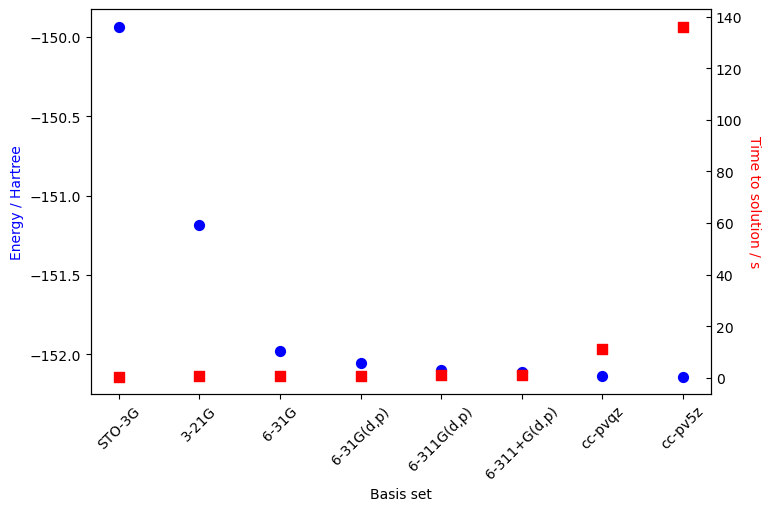

In [19]:
import matplotlib.pyplot as plt

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(8,5))

# Plot the energies.
ax.set_xticks(range(len(basis_sets)), basis_sets, rotation=45)
ax.set_xlabel("Basis set")
ax.set_ylabel("Energy / Hartree", color="b")
ax.scatter(range(len(basis_sets)), mf_energies, marker="o", s=50, color="b")

# Plot the time to solution
ax_time = ax.twinx()
ax_time.scatter(range(len(basis_sets)), mf_times, marker="s", s=50, color="r")
ax_time.set_ylabel("Time to solution / s", color="r", rotation=270, va="bottom")

# Show the graph
plt.tick_params(axis="both", direction="in")
plt.show()

On note sur ce graphique que l’augmentation de la complexité de l'ensemble de base rapproche la valeur propre de l’énergie de la véritable énergie de Hartree-Fock. Cette tendance peut également être généralisée à d'autres méthodes, comme [CCSD](https://en.wikipedia.org/wiki/Coupled_cluster), [MP2](https://en.wikipedia.org/wiki/M%C3%B8ller%E2%80%93Plesset_perturbation_theory), [FCI](https://en.wikipedia.org/wiki/Full_configuration_interaction), etc., bien que le temps de résolution serait plus long pour ces approches post Hartree-Fock. Ce qu’il faut retenir, c’est que même si une base infinie est nécessaire pour converger vers la véritable énergie, il y a des rendements décroissants à un moment donné, surtout si l’on considère le temps requis pour le calcul. Dans notre cas, `6-311G(d,p)` ou `6-311+G(d,p)` apparaît comme un bon choix en termes de précision et de temps de calcul.

### <a id='toc1_4_6_'></a>[Prise en compte de l'énergie de corrélation - Potentiel de l'informatique quantique](#toc0_)

Les méthodes Post Hatree-Fock sont destinées à prendre en compte l'énergie de corrélation électronique. L'énergie de corrélation est définie comme
$$
E_{\text{corr}} = E_{\text{FCI}} - E_{\text{HF}},
$$
dans lequel $E_{\text{FCI}}$ et $E_{\text{HF}}$ sont les énergies calculées à partir de la diagonalisation exacte de l'Hamiltonien moléculaire dans l'approximation de Born-Oppenheimer, c'est-à-dire l'interaction de configuration complète (FCI), et la méthode Hartree-Fock, respectivement. Puisqu'il est prohibitif sur le plan computationnel de résoudre le problème FCI, à l'exception de très petits systèmes, il est courant d'introduire des approximations pour inclure les effets de corrélation dans les calculs de structure électronique. Le problème FCI considère la diagonalisation de l'Hamiltonien dans une base de tous les déterminants excités possibles, c'est-à-dire tous les déterminants possibles à 1, 2, 3,…, N corps pour un système à N électrons. Par conséquent, la fonction d’onde FCI est une combinaison linéaire de tous les déterminants possibles pour un système à N électrons. Les méthodes approximatives n'incluent qu'un sous-ensemble des déterminants excités dans la fonction d'état approximative afin de capturer les effets de corrélation les plus importants (par exemple, théorie des perturbations à plusieurs corps, théorie des clusters couplés).

Cette énergie de corrélation peut être divisée en deux catégories : **corrélation statique** et **dynamique**. Pour considérer le premier cas, il faut utiliser des approches multi-configurations. Ces dernières peuvent être abordées avec des méthodes post Hartree-Fock avec un seul état de référence, comme Configuration Interaction (CI), Coupled-Cluster (CC) ou des méthodes perturbatives (MP2, MP3, .etc).

Nous avons vu dans la section précédente que le `6-311G(d,p)` est un bon compromis pour calculer l'état fondamental du dimère d'eau. Sur cet ensemble de bases, cette molécule est décrite par 94 bases (orbitales de spin) et 20 électrons. Pour obtenir la plus haute fidélité par rapport à la vraie fonction d'état avec la meilleure méthode actuelle (la FCI), il faudrait ${94 \choose 20} \approx 3 \times 10^{13}$ configurations. Même si nous parvenions d’une manière ou d’une autre à représenter chaque configuration sous la forme d’un seul octet de données, 4,11 pétaoctets seraient encore nécessaires pour stocker la fonction d’état complète de la molécule de dimère d'eau. Cet effet est amplifié lorsqu’il s’agit de molécules industrielles pertinentes telles que des complexes organométalliques ou des protéines. Passer par le formalisme classique de la chimie quantique n’est donc pas une solution viable.

Avec la transformation de Jordan-Wigner, ce problème disparaît. En exploitant le principe de superposition quantique de manière simple, il est possible de mapper cet état fondamental du dimère d'eau sur 94 qubits (les orbitales de spin vides et remplies sont mappées sur les $|0\rangle$ et $|1\rangle$ États, respectivement). Ce fait explique l’enthousiasme naissant de la communauté du calcul quantique pour les applications chimiques. Notons que même si la limitation spatiale est atténuée, aucun consensus n'est établi sur la complexité temporelle, corrélée au nombre de portes et de mesures nécessaires pour approximer la fonction d'état moléculaire.

## <a id='toc1_5_'></a>[Réduction des ressources](#toc0_)

**La réduction des ressources fait référence à la réduction des exigences de calculs pour exécuter un algorithme.** Cela s’applique à la fois à l’informatique classique et quantique. En informatique conventionnelle, cela se traduit par moins de bits requis pour stocker les informations et moins d’opérations à effectuer sur ces bits. Pour l’informatique quantique à modèle de portes, cela se traduit par une réduction du nombre de qubits et du nombre de portes dans les circuits quantiques.

La molécule de dimère d'eau dans la base `6-311G(d,p)` nécessiterait 94 qubits et intrinsèquement un circuit quantique considéré comme trop profond pour les architectures actuelles (dispositifs NISQ). La réduction du nombre de qubits requis pour coder le problème constitue le premier moyen indirect de réduire ces exigences. Les deux méthodes discutées ci-dessous sont la réduction de **l'espace actif** et la **prise en compte des symétries moléculaires**.

### <a id='toc1_5_1_'></a>[Sélection d'espace actif](#toc0_)

La **sélection d'espace actif** *est un moyen de réduire le nombre de qubits en ignorant certaines orbitales moléculaires dans le calcul post-Hartree-Fock*. A cet effet, on classe  les orbitales moléculaires en orbitales doublement occupées, actives et externes :

* les orbitales doublement occupées (**core orbitals**) sont toujours occupées par deux électrons;
* les orbitales actives (**valence orbitals**) peuvent être occupées par zéro, un ou deux électrons.
* les orbitales externes (**virtual orbitals**) ne sont jamais occupées.

<!-- <center><img src="Graphics/Sketch_active_space.png" width="450"/></center> -->
![Sketch_active_space.png](Graphics/Sketch_active_space.png)

Dans cette approximation, un certain nombre d'*électrons actifs* peuvent peupler les *orbitales actives* à partir desquelles nous pouvons générer un espace de taille finie de déterminants de Slater.

**Note**</br>
Le nombre de *spin-orbitales actives* détermine le *nombre de qubits* requis pour effectuer des simulations quantiques de la structure électronique de la molécule. Appliquer cette méthode est trivial, mais choisir les orbitales moléculaires à geler ne l’est pas.

 Bien qu’il n’existe pas d’algorithme général pour effectuer cette opération, on peut évaluer quelles orbitales geler en imprimant d’abord les occupations des orbitales moléculaires.

In [ ]:
DWat_mol.basis = "6-311+G(d,p)"
DWat_mol.build()
DWat_mol.verbose = 0
n_mos = DWat_mol.nao_nr()
print(f'Le nombre d\'orbitales moléculaires, dans la base {DWat_mol.basis}, est {n_mos}')
mf = scf.RHF(DWat_mol)
mf.kernel()
mf.mo_occ

Le nombre d'orbitales moléculaires, dans la base 6-311+G(d,p), est 68


array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Une façon d’imaginer cela est de considérer uniquement les orbitales frontières (HOMO, LUMO) et leurs voisines. La corrélation perdue sur l’énergie totale en considérant uniquement un sous-ensemble de l’espace actif complet peut être faible. Par exemple, le gel des orbitales moléculaires bassement occupées est connu sous le nom d'**approximation du noyau gelé** ou **frozen-core approximation** et peut être appliqué car les orbitales du coeur ne se mélangent pas avec les orbitales de valence. Il existe également des algorithmes pour geler les orbitales virtuelles, comme la méthode de troncature des orbitales naturelles gelées (FNO) [[Collect. Tchèque. Chimique. Commun. 2005, 70, 837-850](https://doi.org/10.1135/cccc20050837) et [J. Chimique. Phys. 2008, 128, 164101](https://doi.org/10.1063/1.2902285)]. Même si le choix d'un espace actif approprié peut résoudre un problème, cela peut contribuer à réduire *a priori* les ressources quantiques.

La cellule de code ci-dessous aboutit à la prise en compte des orbitales moléculaires proches du niveau HOMO-LUMO. La fonction `get_active_orbitals_with_homo_lumo` aide les utilisateurs à obtenir les étiquettes de ces orbitales. Dans notre cas, l'espace actif est défini du HOMO-3 au LUMO+3.

In [ ]:
def get_active_orbitals_with_homo_lumo(n_mos, molecule, homo_minus_n=0, lumo_plus_n=0):
    """Function that returns a list of active orbitals if the user wants to
    consider only a subset from HOMO(-homo_min_n) to LUMO(+lumo_plus_n)
    orbitals. Users should be aware of degeneracies, as this function does not
    take this property into account.

    Args:
        n_mos: Number of molecular orbitals
        molecule (mf object): pyscf meam-field object of the molecule to be evaluated.
        homo_minus_n (int): Starting point at HOMO - homo_minus_n.
        lumo_plus_n (int): Ending point at LUMO + lumo_plus_n.

    Returns:
        list of int: orbitals in the active space.
    """

    # Index of HOMO and LUMO
    lumo_idx = molecule.mo_occ.tolist().index(0.)
    homo_idx = lumo_idx - 1

    active_orbitals = homo_idx-homo_minus_n, lumo_idx+lumo_plus_n+1

    return active_orbitals


In [ ]:
# Selecting HOMO-3 to LUMO+3 orbitals
active_space = get_active_orbitals_with_homo_lumo(n_mos, mf, homo_minus_n=3, lumo_plus_n=3)
n_active_mos = active_space[1]-active_space[0]
print(f'Le nombre de MOs dans l\'espace actif est {n_active_mos} et les indexes correspondants sont {list(range(active_space[0],active_space[1]))}')

Le nombre de MOs dans l'espace actif est 8 et les indexes correspondants sont [6, 7, 8, 9, 10, 11, 12, 13]


In [ ]:
frozen_orbitals = [n for n in range(n_mos) if n not in range(active_space[0],active_space[1])]

En suivant cette approche, nous réduisons le nombre d'orbitales considérées de 68 à 8. Avec les mappages fermions-qubits conventionnels, le nombre de qubits peut être réduit de 94 à 16. Bien qu'il s'agisse d'une réduction impressionnante, les configurations impliquant des orbitales inférieures à HOMO- 4 et supérieurs, LUMO+4 ne sont pas pris en compte ici. Cela se traduit par une énergie plus éloignée de la véritable énergie car rien ne nous dit que ces configurations ne sont pas pertinentes *a priori*. Dans la cellule de code suivante, nous considérons le calcul CCSD du dimère d'eau avec et sans ces orbitales.

In [ ]:
from pyscf import cc

#
# Without Frozen orbitals
#
mycc = cc.CCSD(mf)
mycc.kernel()
print('CCSD correlation energy', mycc.e_tot)

#
# With Frrozen orbitals 
#
mycc_fr = cc.CCSD(mf)
mycc_fr.frozen = frozen_orbitals
mycc_fr.kernel()
print('CCSD correlation energy', mycc_fr.e_tot)

print(f"Energy difference: {abs(mycc.e_tot-mycc_fr.e_tot)*627.5} kcal/mol.")

CCSD correlation energy -152.60944993647917
CCSD correlation energy -152.11412713481522
Energy difference: 310.8150580441259 kcal/mol.


Ce choix se traduit par une différence d'énergie de plus de 310 kcal/mol, bien supérieure à [précision chimique](https://en.wikipedia.org/wiki/Computational_chemistry) (1 kcal/mol). Dans cette situation, la limite inférieure avec l’espace actif réduit est supérieure à l’état fondamental du CCSD. Ce qu’il faut retenir, c’est d’être prudent lors du choix d’un espace actif pour une molécule.

Restreignons maintenant l'espace actif à l'HOMO et au LUMO.

In [ ]:
#
# Without Frozen orbitals
#
mycc = cc.CCSD(mf)
mycc.kernel()
print('CCSD correlation energy', mycc.e_tot)

#
# With Frrozen orbitals 
#
mycc_fr = cc.CCSD(mf)
mycc_fr.frozen = (0,homo_idx)
mycc_fr.kernel()
print('CCSD correlation energy', mycc_fr.e_tot)

print(f"Energy difference: {abs(mycc.e_tot-mycc_fr.e_tot)*627.5} kcal/mol.")

CCSD correlation energy -152.6094499364791
CCSD correlation energy -152.49514048607853
Energy difference: 71.72918012636586 kcal/mol.


On constate une amélioration du résultat avec une différence d'énergie de plus de 71.73 kcal/mol.

### <a id='toc1_5_2_'></a>[Considérations de symétries](#toc0_)

Les symétries moléculaires se reflètent dans la structure Hamiltonienne. Le nombre d'électrons dans la molécule doit être cohérent avant et après l'application de l'ansatz sur l'état initial. Les configurations électroniques ne respectant pas cette symétrie peuvent donc être négligées sans perte de précision. En chimie quantique, cela conduit à un nombre plus petit de qubits dans les algorithmes VQE. Nous aborderons celà dans un tutorial specifique aux VQA.

## <a id='toc1_6_'></a>[Analyse du champ moyen](#toc0_)

On utilise la méthode `analyze` de l'objet de champ moyen pour imprimer les propriétés moléculaires pertinentes. 

In [ ]:
mf.verbose = 3
mf.analyze()

**** MO energy ****
MO #1   energy= -20.5932281727734  occ= 2
MO #2   energy= -20.535363983435   occ= 2
MO #3   energy= -1.38321116059041  occ= 2
MO #4   energy= -1.32497133424237  occ= 2
MO #5   energy= -0.746183395384089 occ= 2
MO #6   energy= -0.697352399403849 occ= 2
MO #7   energy= -0.615938881453301 occ= 2
MO #8   energy= -0.560443868912869 occ= 2
MO #9   energy= -0.531611799879646 occ= 2
MO #10  energy= -0.48151737282833  occ= 2
MO #11  energy= 0.120641619765137  occ= 0
MO #12  energy= 0.17362623646586   occ= 0
MO #13  energy= 0.197322368959239  occ= 0
MO #14  energy= 0.219164141788803  occ= 0
MO #15  energy= 0.230150861277798  occ= 0
MO #16  energy= 0.242434387435641  occ= 0
MO #17  energy= 0.277136264443283  occ= 0
MO #18  energy= 0.280718612556083  occ= 0
MO #19  energy= 0.295133919372524  occ= 0
MO #20  energy= 0.323611677407391  occ= 0
MO #21  energy= 0.396027972673008  occ= 0
MO #22  energy= 0.443385862543417  occ= 0
MO #23  energy= 0.647462984198303  occ= 0
MO #24  energy

 ** Mulliken atomic charges  **
charge of    0O =     -0.71456
charge of    1H =      0.33544
charge of    2H =      0.35221
charge of    3O =     -0.67767
charge of    4H =      0.35229
charge of    5H =      0.35229
Dipole moment(X, Y, Z, Debye):  2.78416,  0.13005,  0.00000


((array([1.99999109e+00, 1.64135937e+00, 5.10722316e-03, 1.43215044e-03,
         4.50500939e-04, 1.45208139e+00, 1.60005388e+00, 1.98510338e+00,
         6.39904139e-03, 3.15131531e-03, 7.45730520e-03, 1.28104040e-03,
         1.21176901e-03, 7.33480869e-04, 1.48143505e-04, 1.62815200e-04,
         4.15746098e-04, 1.69805199e-03, 7.04904706e-04, 2.19931811e-03,
         1.89807934e-04, 3.23207350e-03, 6.42855575e-01, 1.02614042e-02,
         5.79898465e-03, 1.29150150e-03, 1.62161308e-03, 2.73564048e-03,
         6.26462443e-01, 9.42913804e-03, 6.02698379e-03, 2.21664241e-03,
         1.09662188e-03, 2.55831104e-03, 1.99999103e+00, 1.63908040e+00,
         4.29975540e-03, 1.44072017e-03, 4.64928114e-04, 1.86616654e+00,
         1.78404603e+00, 1.35124185e+00, 5.61939898e-03, 2.74866717e-03,
         8.93733616e-03, 1.90909680e-03, 1.31808443e-03, 1.49871032e-03,
         5.03204232e-04, 3.04591087e-04, 6.86089679e-06, 1.90332134e-03,
         3.26976467e-03, 4.86411944e-04, 1.37921874